In [1]:
##Импорт необходимых модулей
import pandas as pd
import re
import transliterate as tr
import numpy as np
import matplotlib.pyplot as plt

In [2]:
## Чтение таблицы с именами нужных параметров и их кодировкой для финальной таблицы
param_names=pd.read_excel('analyzes_epi.xlsx',encoding='cp-1251')
## Удаление пробелов в именах
param_names['param_input']=param_names['param_input'].apply(lambda x: x.replace(' ',''))
param_names.index=param_names['param_input']

##Превращение файла в словарь вида {исходное название: необходимое название}
param_names=param_names['param_out'].to_dict()

In [ ]:
##Открытие основного файла с анализами
f=open('table.txt','r')
data=' '.join(i for i in f)
data=re.split('\n \n',data)

In [ ]:
##Основной алгорит вычленения анализов в таблицу 
types=set(['Биохимия крови', 'Коагулограмма','нализ крови','нализ ликвора','нализ мочи'])
result_list=[]
for i in data:
    if re.search(r'[А-Я$а-я]+',i)==None: continue
    set_of_dates=re.split('(\d{2}[.]\d{2}[.]\d{2})',i)
    digits=re.findall('\d+',set_of_dates[0])
    
    clinic_numb=int(digits[0])
    age=digits[1]
    name=tr.translit(re.findall(r'[А-Я$а-я]+',i)[0], reversed=True)
    for date in range(1,len(set_of_dates),2):
        date_time=set_of_dates[date]
        text=set_of_dates[date+1][set_of_dates[date+1].find(' '):]
        for typ in types:
            if typ in text:
                analyse_type=typ
                break
            else: analyse_type='Not recognised'
        params=text[text.find(':'):]
        params=params.split(',')
        for param in params:
            param_name2=param[param.find(' ')+1:param.find('-')]
            param_name=param_name2.replace(' ','')
            param=param[param.find('-')+1:]
            value=param[:param.find('(')]
            result_list.append([clinic_numb,name,age,date_time,analyse_type,param_name,value,param_name2])
## Климочкин и Прямухин удалены из базы

q=pd.DataFrame(result_list,columns=['clinic_numb','name','age','date','type','param','value','real_param_name'])
q=q[q['param'].apply(lambda x: re.findall(r'[а-я]+',x)!=[])]

In [ ]:
## Обработка получившейся ДБ

    ##Присвоение правильных имен всем параметрам 
def namer(param):   
    for i in param_names:
        if i==param:
            return(param_names[i])
def same_name_in_dif_tests(param):
    if param['param'] in ['глюкоза', 'белок']:
        if param['type']=='нализ мочи': return(param['param_name']+'_urine')
        if param['type']=='нализ ликвора': return(param['param_name']+'_cerebral')
        if param['type']=='Биохимия крови': return(param['param_name']+'_blood')
    else: return(param['param_name'])

q['param_name']=q['param'].apply(namer)
q['param_name']=q.apply(same_name_in_dif_tests,axis=1)

##Чистка значений

    ##Выкидываем все значения из списка лимфоциты, моноциты и т.д. которые не в процентах, а в количествах 
for i in ['GR','NEU','MON','LYM','EOS','BAS']:
    for j in q[q['param_name']==i].index:
        if '^' in q.loc[j]['value']: q.drop(j, axis=0,inplace=True)
            
    ## Выкидываем все измерения лейкоцитов и эритроцитов в моче
for i in ['RBC','WBC','RBC_1','WBC_1']:
    for j in q[q['param_name']==i].index:
        if 'п/з' in q.loc[j]['value']:
            q.drop(j, axis=0,inplace=True)

q.value=q.value.apply(lambda x: x[:x.find(' ')] if ' ' in x  else x)
q.value=q.value.apply(lambda x: x[:x.find('%')] if '%' in x  else x)


In [ ]:
##Вычисление через сколько дней после поступления был сделан тот или иной анализ
def days_error(days):
    if (days<0) or (days>360):
        if (days%365 in range(-4,4)) or (days%365 in range(360,366)): return(1)
    else: return(days)
fulldf=pd.read_csv('stroke_table.csv',sep=';', encoding='cp1251',skiprows=[1])
w=pd.merge(fulldf[['clinic_numb','adm_date']],q,left_on='clinic_numb',right_on='clinic_numb',how='inner')
w.adm_date=w.adm_date.apply(lambda x: x.replace(',','.'))
w['days_after_adm']=pd.to_datetime(w['date'],dayfirst=True)-pd.to_datetime(w['adm_date'],dayfirst=True)
w['days_after_adm']=w.days_after_adm.apply(lambda x: x.days)
w['days_after_adm']=w.days_after_adm.apply(days_error)
w.sort_values('days_after_adm', inplace=True)

In [ ]:
##Создание финальной таблицы с осями Фамилия/Параметр

##Выбор только тех параметров которые есть в таблице с нужными параметрами
w=w[w.param_name.notna()]
##Выбор параметров с корректными датами анализов после поступления больного
w=w[w['days_after_adm'].notna()]

##Функция выбора самого раннего значения параметра для создания финальной таблицы
def sorter(x):
    days=w.loc[x.index[0],'days_after_adm']
    value=w.loc[x.index[0],'value']
    if len(x.index)>1:
        for i in x.index:
            if w.loc[i,'days_after_adm']<days:
                value=w.loc[i,'value']
                days=w.loc[i,'days_after_adm']
    return(value)

##Непосредственное создание таблицы с аггрегацией функцией sorter
final_tab=pd.pivot_table(data=w,index=['name','clinic_numb'],columns='param_name',values='value',aggfunc=sorter)

# ##Превращение всех значений в числовые значения
for i in final_tab.columns:
    final_tab[i] = pd.to_numeric(final_tab[i], errors='coerce')
final_tab.to_excel('result_table.xlsx')

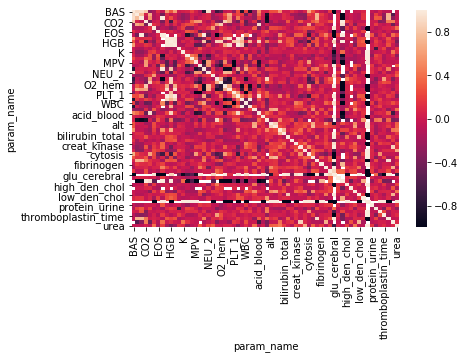

In [407]:
import seaborn as sns
sns.heatmap(final_tab.corr())